<a href="https://colab.research.google.com/github/sophie-bell8/deep-learning/blob/main/Deep_Learning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package and Data Loading


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Deep Learning/ISIC_data.zip", 'r')
zip_ref.extractall("/ISIC_data")
zip_ref.close()

In [ ]:
import shutil
shutil.unpack_archive("/content/drive/My Drive/Deep Learning/ISIC_data.zip", "ISIC_data")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping
from tensorflow.keras.models import * 
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import random
import os
import tensorflow as tf
assert len(tf.config.list_physical_devices('GPU'))>0
# packages for classification report
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import *
import seaborn as sns
sns.set_theme(style="whitegrid")
from sklearn.utils import class_weight
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
!nvidia-smi
# checking what GPU is used for methodology

Thu May 19 16:29:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# using a newer version of matplotlib so bar_label can be used for charts
!pip install matplotlib --upgrade

In [ ]:
filenames=os.listdir("../ISIC_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
categories=[]

In [ ]:
print(filenames)

['actinic keratosis', 'melanoma', 'basal cell carcinoma', 'vascular lesion', 'nevus', 'seborrheic keratosis', 'pigmented benign keratosis', 'dermatofibroma', 'squamous cell carcinoma']


### General Settings for Models/Data

In [ ]:
# parameters are outlined here to ensure consistency in the models for comparison
batch_size = 32
img_height = 224
img_width = 224
directory = '../ISIC_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_directory = '../ISIC_data/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

In [ ]:
epochs=50
shape = (224,224,3)
SGD_opt = SGD(learning_rate=0.0001, momentum=0.9)
Adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
num_classes = 9
batch_size=32

In [ ]:
callbacks = [ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
            #  EarlyStopping(monitor ="accuracy", 
            #                           mode ="min", patience = 5, 
            #                           restore_best_weights = True)
            ]

# early stopping was removed due to the negative effect on performance

# Image Generator

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               validation_split=0.3)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

In [ ]:
train_ds = train_gen.flow_from_directory(directory,
                                         target_size=(224,224),
                                         batch_size=batch_size,
                                         class_mode = 'categorical',
                                         subset='training')
valid_ds = val_datagen.flow_from_directory(directory,
                                         target_size=(224,224),
                                         batch_size=batch_size,
                                         class_mode = 'categorical',
                                         subset='validation')

Found 1571 images belonging to 9 classes.
Found 668 images belonging to 9 classes.


In [ ]:
train_ds.class_indices

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'seborrheic keratosis': 6,
 'squamous cell carcinoma': 7,
 'vascular lesion': 8}

# Data Summary

### Training Data Summary

In [ ]:
# counting images in the train dataset
path = "../ISIC_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/" 
folders  = os.listdir(path)
print(folders) 

## Counting the number of images per folder in the dataset
for folder in folders: 
  imgs = os.listdir(path+folder) 
  print("In the folder " + folder + " there are " + str(len(imgs))+ " images" )

['actinic keratosis', 'melanoma', 'basal cell carcinoma', 'vascular lesion', 'nevus', 'seborrheic keratosis', 'pigmented benign keratosis', 'dermatofibroma', 'squamous cell carcinoma']
In the folder actinic keratosis there are 114 images
In the folder melanoma there are 438 images
In the folder basal cell carcinoma there are 376 images
In the folder vascular lesion there are 139 images
In the folder nevus there are 357 images
In the folder seborrheic keratosis there are 77 images
In the folder pigmented benign keratosis there are 462 images
In the folder dermatofibroma there are 95 images
In the folder squamous cell carcinoma there are 181 images


In [ ]:
# putting the train dataset in a dataframe to create visual
d = {'Class': ['actinic keratosis', 'vascular lesion', 'nevus','seborrheic keratosis', 'melanoma', 'squamous cell carcinoma', 'dermatofibroma', 'basal cell carcinoma', 'pigmented benign keratosis' ], 'Number of Images': [114, 139,357,77,438,181,95,376,462]}
train_df = pd.DataFrame(data=d)


In [ ]:
# chart showing the number of images in each class
# runtime has to be ended and restarted to use this chart as a newer version of matplotlib is used
plt.figure(figsize=(8, 6))
splot=sns.barplot(x="Number of Images",y="Class",palette="Blues_d",data=d)
plt.xlabel("Number of Images", size=16)
plt.ylabel("Classes", size=16)
plt.bar_label(splot.containers[0])
plt.title('Images Per Class (Train)')


### Test Data Summary

In [ ]:
# counting images in the test dataset
path_test = "../ISIC_data/Skin cancer ISIC The International Skin Imaging Collaboration/Test/" 
folders  = os.listdir(path_test)
print(folders) 

## Counting the number of images per folder in the dataset
for folder in folders: 
  imgs = os.listdir(path_test+folder) 
  print("In the folder " + folder + " there are " + str(len(imgs))+ " images" )

['actinic keratosis', 'melanoma', 'basal cell carcinoma', 'vascular lesion', 'nevus', 'seborrheic keratosis', 'pigmented benign keratosis', 'dermatofibroma', 'squamous cell carcinoma']
In the folder actinic keratosis there are 16 images
In the folder melanoma there are 16 images
In the folder basal cell carcinoma there are 16 images
In the folder vascular lesion there are 3 images
In the folder nevus there are 16 images
In the folder seborrheic keratosis there are 3 images
In the folder pigmented benign keratosis there are 16 images
In the folder dermatofibroma there are 16 images
In the folder squamous cell carcinoma there are 16 images


In [ ]:
d2 = {'Class': ['actinic keratosis', 'vascular lesion', 'nevus','seborrheic keratosis', 'melanoma', 'squamous cell carcinoma', 'dermatofibroma', 'basal cell carcinoma', 'pigmented benign keratosis' ], 'Number of Images': [16, 3,16,3,16,16,16,16,16]}
test_df = pd.DataFrame(data=d2)

In [ ]:
# chart showing the number of images in each class
# runtime has to be ended and restarted to use this chart as a newer version of matplotlib is used
plt.figure(figsize=(8, 6))
splot=sns.barplot(x="Number of Images",y="Class",palette="Greens_d",data=d2)
plt.xlabel("Number of Images", size=16)
plt.ylabel("Classes", size=16)
plt.bar_label(splot.containers[0])
plt.title('Images Per Class (Test)')

## Class Weighting

The below was how i tried to implement class weights, although i could implement this into the model when compiling the effect on performance was negative, therefore it was excluded (discussed in report).

In [ ]:
class_names = folders
num_classes = len(class_names)
print('\n{} classes:\n{}'.format(num_classes,class_names))


9 classes:
['actinic keratosis', 'melanoma', 'basal cell carcinoma', 'vascular lesion', 'nevus', 'seborrheic keratosis', 'pigmented benign keratosis', 'dermatofibroma', 'squamous cell carcinoma']


In [ ]:
classes=[
    'pigmented benign keratosis',
    'melanoma',
    'vascular lesion',
    'actinic keratosis',
    'squamous cell carcinoma',
    'basal cell carcinoma',
    'seborrheic keratosis',
    'dermatofibroma',
    'nevus'
]

In [ ]:
# generate class weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(train_ds.classes),
                                                  y = train_ds.classes
)

class_weights = dict(zip(np.unique(train_ds.classes), class_weights))
class_weights

{0: 2.1819444444444445,
 1: 0.6611952861952862,
 2: 2.60530679933665,
 3: 0.5685848715164676,
 4: 0.6982222222222222,
 5: 0.5387517146776406,
 6: 3.2325102880658436,
 7: 1.374453193350831,
 8: 1.7811791383219955}

# Models

## Model Inception V3

In [ ]:
inception = InceptionV3(input_shape = shape,
                        include_top = False,
                        weights = 'imagenet'
                        )


In [ ]:
# freeze top layer
inception.layers[0].trainable = False

In [ ]:
# making layers not trainable
for layer in inception.layers:
   layer.trainable = False

In [ ]:
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# added to the InceptionV3 model after making layers not trainable
x = layers.Dropout(0.6)(inception.output)
x = layers.Flatten()(x)
x = layers.Dropout(0.8)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(num_classes, activation='softmax')(x)

inceptionv3 = Model(inception.input, x)
inceptionv3.compile(loss='categorical_crossentropy', optimizer=SGD_opt, metrics=['accuracy'])


In [ ]:
history = inceptionv3.fit(train_ds,
                     epochs=epochs,               
                     validation_data=valid_ds,
                     callbacks=callbacks)
# this is where i was implementing class weights before removing

Epoch 1/50
50/50 [==============================] - 66s 1s/step - loss: 4.7637 - accuracy: 0.1458 - val_loss: 2.0187 - val_accuracy: 0.2216 - lr: 1.0000e-04
Epoch 2/50
50/50 [==============================] - 50s 1s/step - loss: 2.7022 - accuracy: 0.1922 - val_loss: 2.0754 - val_accuracy: 0.1976 - lr: 1.0000e-04
Epoch 3/50
50/50 [==============================] - 48s 960ms/step - loss: 2.3593 - accuracy: 0.2050 - val_loss: 2.0648 - val_accuracy: 0.1961 - lr: 1.0000e-04
Epoch 4/50
50/50 [==============================] - 48s 971ms/step - loss: 2.1804 - accuracy: 0.2202 - val_loss: 2.0519 - val_accuracy: 0.1961 - lr: 1.0000e-04
Epoch 5/50
50/50 [==============================] - 48s 958ms/step - loss: 2.1425 - accuracy: 0.2126 - val_loss: 2.0348 - val_accuracy: 0.1976 - lr: 1.0000e-04
Epoch 6/50
50/50 [==============================] - 49s 988ms/step - loss: 2.0927 - accuracy: 0.2292 - val_loss: 2.0259 - val_accuracy: 0.1961 - lr: 1.0000e-04
Epoch 7/50
50/50 [============================

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255) 
test = test_gen.flow_from_directory(test_directory,
                                         target_size=(224,224),
                                         batch_size=batch_size,
                                         class_mode = 'categorical')
# Evaluate on test data
scores = inceptionv3.evaluate(test)
print("%s%s: %.2f%%" % ("evaluate ",inceptionv3.metrics_names[1], scores[1]*100))

Found 118 images belonging to 9 classes.
4/4 [==============================] - 8s 2s/step - loss: 2.2067 - accuracy: 0.1525
evaluate accuracy: 15.25%


In [ ]:
plot_model(inceptionv3, show_shapes=True, show_layer_names=True)
# an overview of the inception model 

### Inception V3 Charts




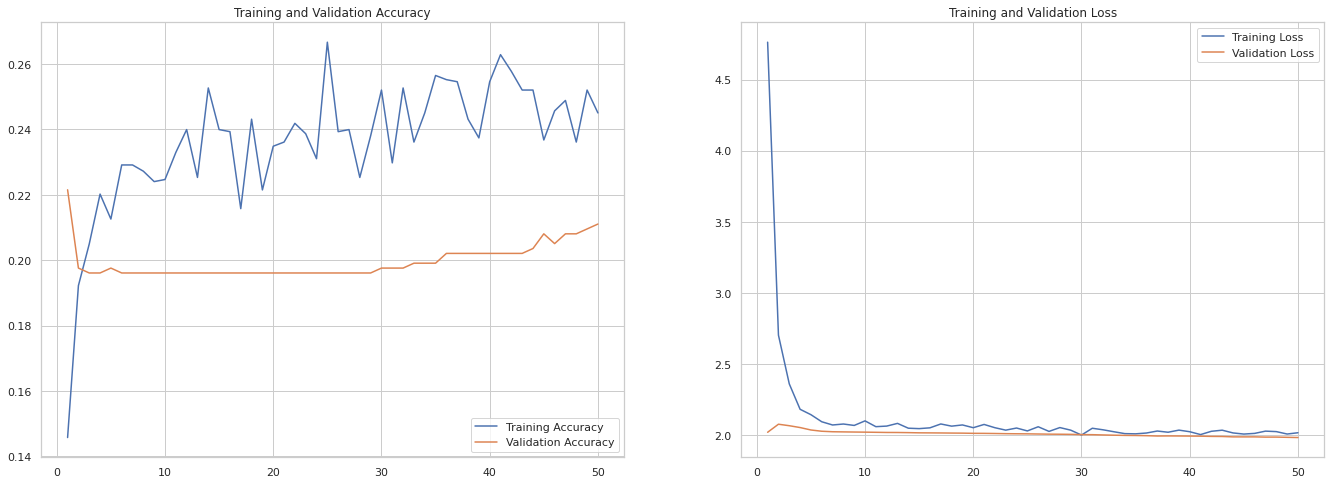

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

metrics = history.history['accuracy']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model VGG16

In [ ]:
model_vgg = vgg16.VGG16(include_top=False,
                        weights = "imagenet",
                        input_shape=shape)

In [ ]:
for layer in model_vgg.layers[:15]:
    layer.trainable = False

# for layer in model_vgg.layers[15:]:
#     layer.trainable = True
    
last_layer = model_vgg.get_layer('block5_pool')
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

model_vgg = tf.keras.models.Model(model_vgg.input, x)

model_vgg.compile(loss='categorical_crossentropy',
              optimizer=SGD_opt,
              metrics=['accuracy'])

model_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
hist = model_vgg.fit(train_ds, 
                             epochs=epochs,                            
                             validation_data=valid_ds, 
                             callbacks = callbacks,
                     )

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255) 
test = test_gen.flow_from_directory(test_directory,
                                         target_size=(224,224),
                                         batch_size=batch_size,
                                         class_mode = 'categorical')
# Evaluate on test data
scores = model_vgg.evaluate(test)
print("%s%s: %.2f%%" % ("evaluate ",model_vgg.metrics_names[1], scores[1]*100))

## Model 4

In [ ]:
model=keras.Sequential()

model.add(layers.Conv2D(32,(5,5),input_shape=shape))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64,(1,1)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(256,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.6))


model.add(layers.Dense(num_classes,activation='softmax')) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 220, 220, 32)      2432      
                                                                 
 activation_94 (Activation)  (None, 220, 220, 32)      0         
                                                                 
 batch_normalization_94 (Bat  (None, 220, 220, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 110, 110, 32)      0         
                                                                 
 conv2d_95 (Conv2D)          (None, 110, 110, 64)      2

In [ ]:
model.compile(optimizer=Adam_opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                     epochs=epochs,                
                     validation_data=valid_ds,
                     callbacks=callbacks)

Epoch 1/50
50/50 [==============================] - 52s 997ms/step - loss: 3.0201 - accuracy: 0.2591 - val_loss: 3.6338 - val_accuracy: 0.1677 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 50s 1s/step - loss: 2.3738 - accuracy: 0.3463 - val_loss: 4.6054 - val_accuracy: 0.1677 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 50s 993ms/step - loss: 2.0649 - accuracy: 0.3966 - val_loss: 3.9738 - val_accuracy: 0.1677 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 49s 983ms/step - loss: 1.9560 - accuracy: 0.3921 - val_loss: 4.9734 - val_accuracy: 0.1781 - lr: 0.0010
Epoch 5/50
50/50 [==============================] - 49s 990ms/step - loss: 1.9270 - accuracy: 0.4176 - val_loss: 3.5058 - val_accuracy: 0.2575 - lr: 0.0010
Epoch 6/50
50/50 [==============================] - 49s 1s/step - loss: 1.8305 - accuracy: 0.4182 - val_loss: 3.5945 - val_accuracy: 0.2260 - lr: 0.0010
Epoch 7/50
50/50 [==============================] - 50s 1s/step - loss

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255) 
test = test_gen.flow_from_directory(test_directory,
                                         target_size=(224,224),
                                         batch_size=batch_size,
                                         class_mode = 'categorical')
# Evaluate on test data
scores = model.evaluate(test)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))


Found 118 images belonging to 9 classes.
4/4 [==============================] - 7s 2s/step - loss: 1.9788 - accuracy: 0.3220
evaluate accuracy: 32.20%


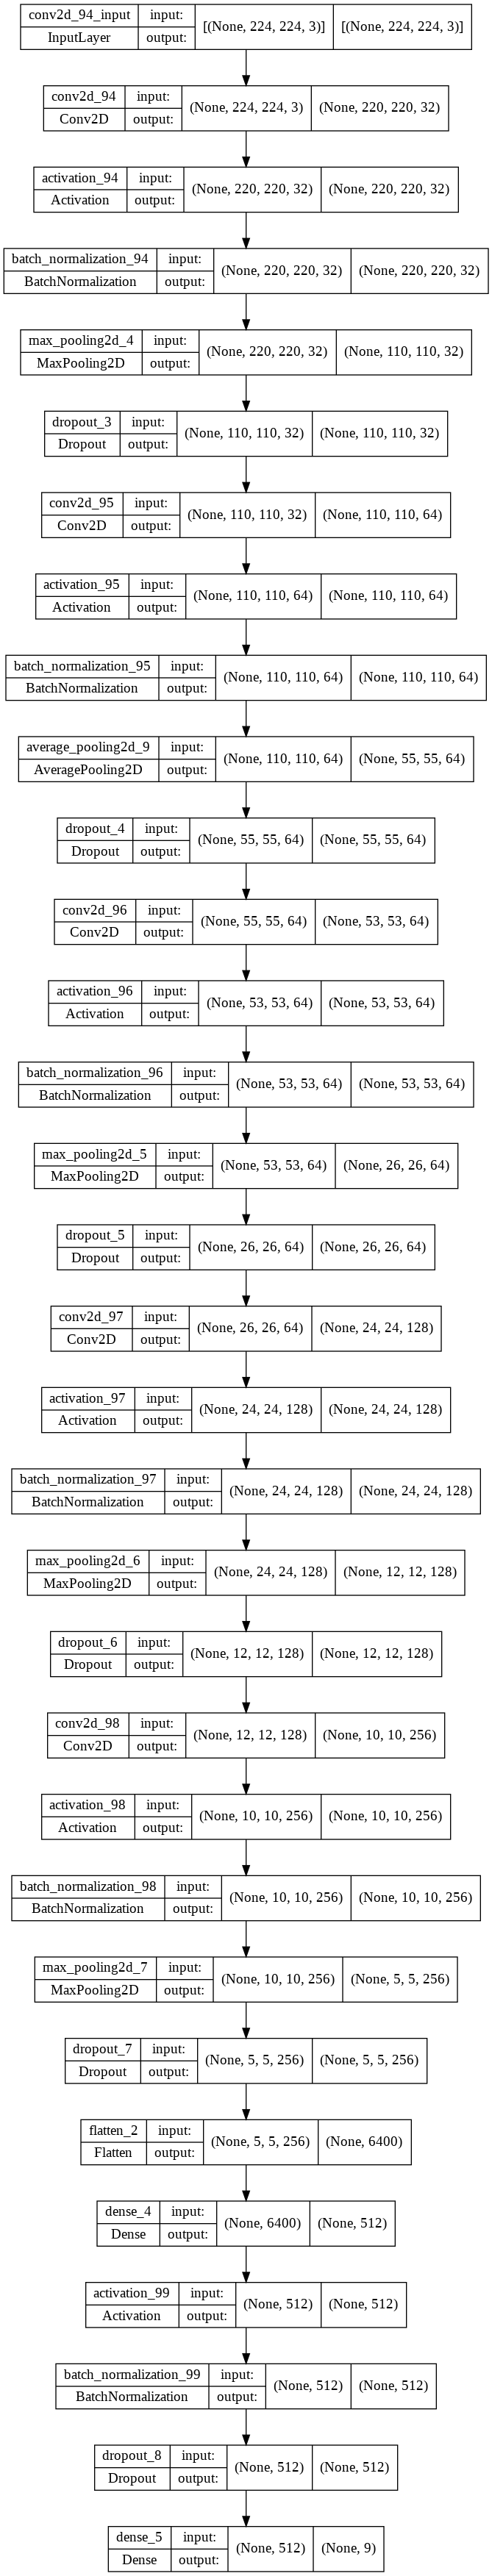

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

### Model 4 Confusion Matrix

In [ ]:
predictions = model.predict(x=test, steps=len(test), verbose=0)

In [ ]:
y_true = test.classes
y_pred = np.argmax(predictions, axis=-1)
cm = confusion_matrix(y_true, y_pred)

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['actinic keratosis', 'vascular lesion', 'nevus','seborrheic keratosis', 'melanoma', 'squamous cell carcinoma', 'dermatofibroma', 'basal cell carcinoma', 'pigmented benign keratosis'], 
                     columns = ['actinic keratosis', 'vascular lesion', 'nevus','seborrheic keratosis', 'melanoma', 'squamous cell carcinoma', 'dermatofibroma', 'basal cell carcinoma', 'pigmented benign keratosis'])

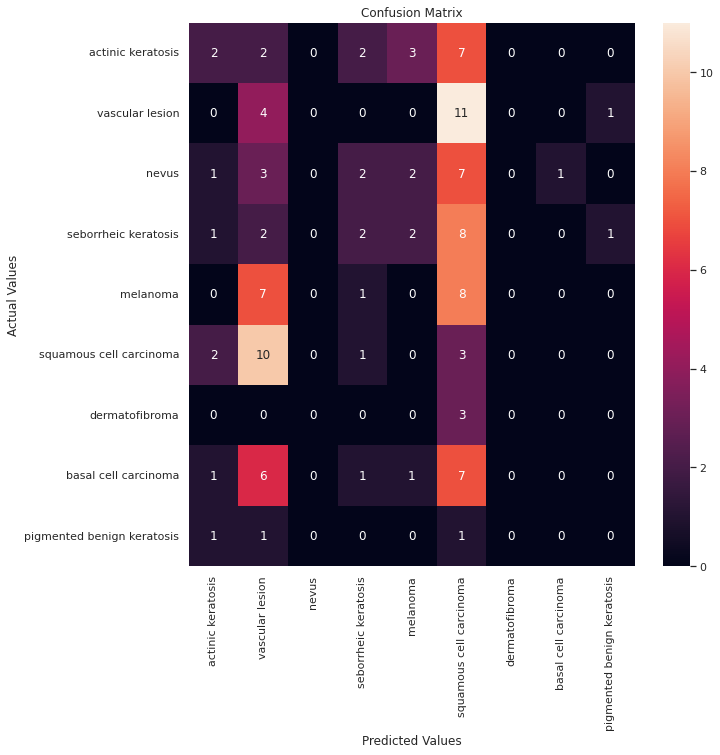

In [ ]:
# Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

### Model 4 Chart

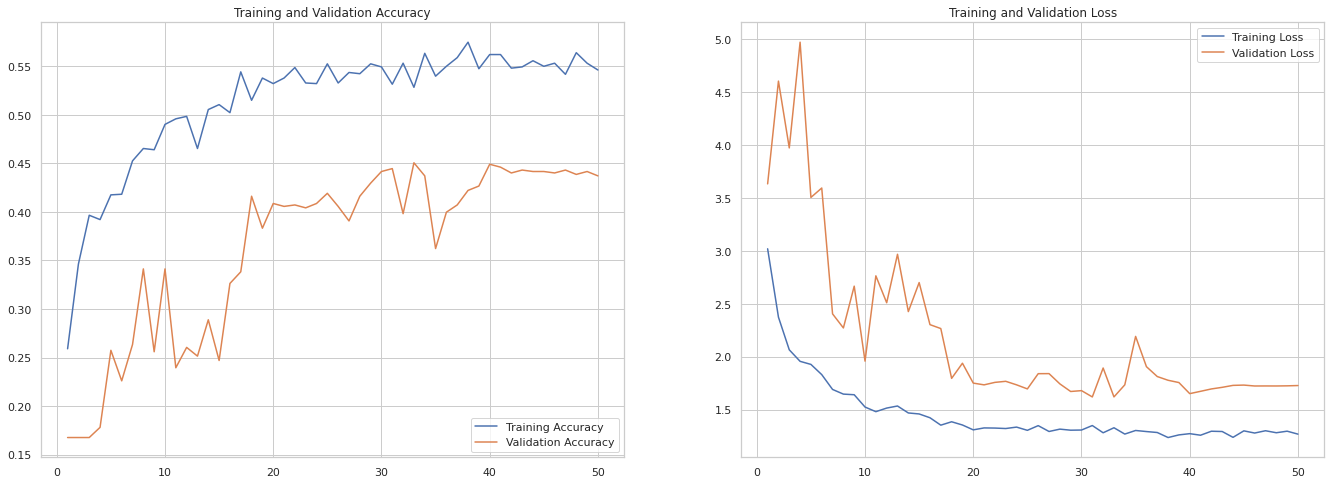

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

metrics = history.history['accuracy']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Confusion Matrix

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

metrics = history.history['accuracy']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Plots and Charts

### Model Plot

In [ ]:
# prints an image of the model
from tensorflow.keras.utils import plot_model
plot_model(model_ResNet50, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Charts

In [ ]:
# y_pred = model.predict(train_ds)
# y_pred_classes = [np.argmax(element) for element in y_pred]

# print("Classification Report: \n", classification_report(train_ds, y_pred_classes))

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
plot_model_history(model_history=history) # validation is at every 50 epochs (change validation steps to lower or epochs to higher)